# Прогнозирование потребления электричества
Источник: https://github.com/vgarshin/arkh_lab В.Гаршин для Архипелаг2035 (2020г.)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import json
import pickle
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, TimeDistributed
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin

In [3]:
pd.set_option('display.max_columns', None)
BASE_PATH = '/content/drive/MyDrive/data'
MODEL_PATH = f'{BASE_PATH}/models'
if not os.path.exists(MODEL_PATH):
    raise ValueError('Нет папки моделей', MODEL_PATH)

print('Версия tensorflow:', tf.__version__)
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu_device in gpu_devices:
        print('Устройсва GPU:', gpu_device)
else:
    print('Не найдено GPU')




Версия tensorflow: 2.4.1
Устройсва GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
# Устанавливаем случайное число для воспроизводимости обучения
def set_all_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_all_seeds(27)

In [5]:
# Загружаем данные
df = pd.read_csv(f'{BASE_PATH}/cpt_power_data.csv', sep='\t', encoding='utf-8', index_col=0)
df['timestamp_value'] = pd.to_datetime(df['timestamp_value'])

In [6]:
# Выбираем первый источник данных для прогноза
ch_serial = df['measuringpoint_serial'].unique()[0]
channel = pd.DataFrame(
    data=list(df[df['measuringpoint_serial'] == ch_serial].value_text),
    index=list(df[df['measuringpoint_serial'] == ch_serial].timestamp_value)
)
channel.columns = ['pwr']
print('Размерность', channel.shape)
channel.head()

Размерность (4416, 1)


,pwr
2018-03-01 00:00:00,87.8
2018-03-01 00:30:00,87.4
2018-03-01 01:00:00,88.4
2018-03-01 01:30:00,88.8
2018-03-01 02:00:00,88.0


### Обогащение данными: признаки дней недели

In [7]:
channel['n_day'] = channel.index.day.astype(np.int8)
channel['n_week'] = channel.index.week.astype(np.int8)
channel['n_month'] = channel.index.month.astype(np.int8)
channel['w_day'] = channel.index.weekday.astype(np.int8)
channel['is_weekend'] = (channel['w_day'] >= 5).astype(np.int8)
channel.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


,pwr,n_day,n_week,n_month,w_day,is_weekend
2018-03-01 00:00:00,87.8,1,9,3,3,0
2018-03-01 00:30:00,87.4,1,9,3,3,0
2018-03-01 01:00:00,88.4,1,9,3,3,0
2018-03-01 01:30:00,88.8,1,9,3,3,0
2018-03-01 02:00:00,88.0,1,9,3,3,0


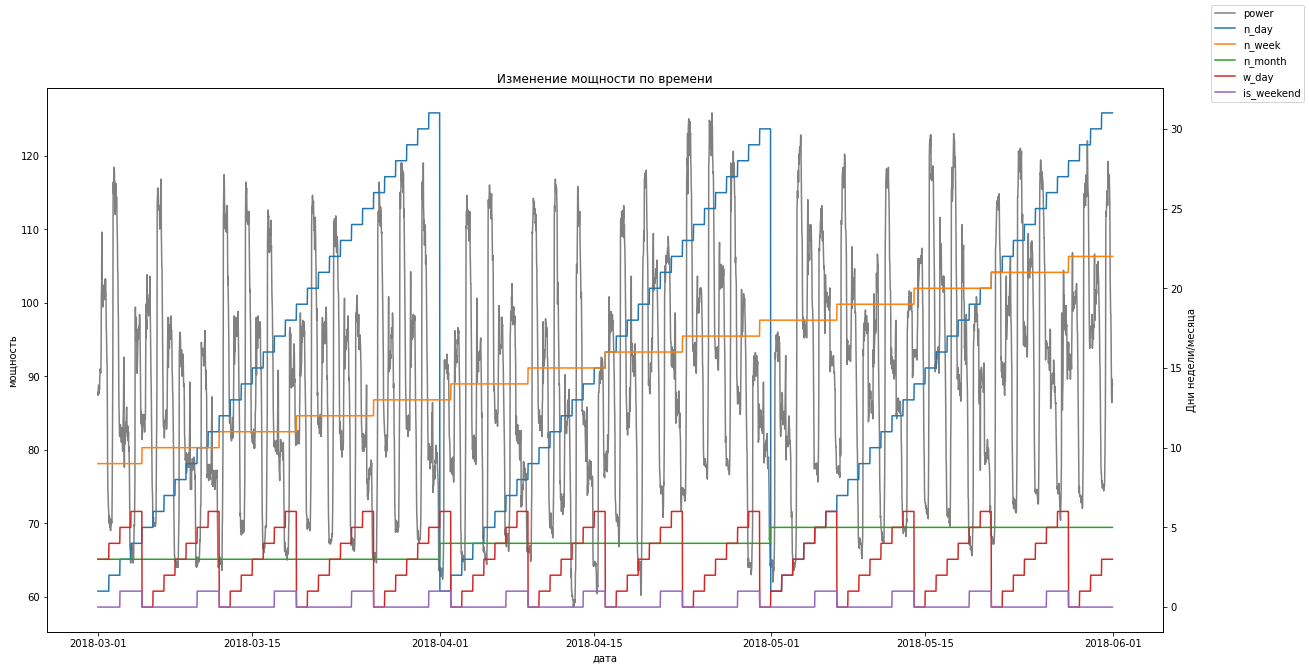

In [8]:
fig, ax1 = plt.subplots(figsize=(20, 10))

ax1.set_xlabel('дата')
ax1.set_ylabel('мощность')
ax1.plot(channel.index, channel.pwr, label='power', color='gray')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('Дни недели/месяца')
for col in [x for x in channel.columns if '_' in x]:
    ax2.plot(channel.index, channel[col], label=col)
ax2.tick_params(axis='y')

fig.legend()
plt.title('Изменение мощности по времени')
plt.show()

### Base-line модель: подготовка данных

Полезная статья по LSTM для прогнозирования временных рядов https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

Статья про аналогичную задачу https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In [9]:
print('Подготавливаем вектор данных')
scaler, scaler_pwr = MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1))
# Трансформируем в вертикальный вектор для построчной нормализаци и нормализуем в значения от 0 до 1.
scaler_pwr.fit(channel['pwr'].to_numpy().reshape(-1, 1))
with open(f'{MODEL_PATH}/scaler_pwr.pkl', 'wb') as file:
    pickle.dump(scaler_pwr, file)
channelScaler = scaler.fit_transform(channel)
print('Всего рядов данных:', len(channelScaler))
print('Примеры:\n', channelScaler[0], '\n',channelScaler[int(len(channelScaler)/2)], '\n', channelScaler[-1])


Подготавливаем вектор данных
Всего рядов данных: 4416
Примеры:
 [0.43452381 0.         0.         0.         0.5        0.        ] 
 [0.30952381 0.5        0.53846154 0.5        0.         0.        ] 
 [0.44940476 1.         1.         1.         0.5        0.        ]


In [10]:
def get_dataset(series, col_look, look_back, look_fwd, cols_features):
    X, y = [], []
    for i in range(len(series[:, col_look]) - look_back - look_fwd):
        temp_X = []
        temp_X.append(series[:, col_look][i:(i + look_back)])
        for col in cols_features:
            temp_X.append(series[:, col][(i + look_fwd):(i + look_back + look_fwd)])
        X.append(temp_X)
        y.append(series[:, col_look][(i + look_back):(i + look_back + look_fwd)])
    return np.array(X), np.array(y)

In [11]:
look_fwd = 7 * 24 * 2 # days * hours * half an hour
print('Прогноз на рядов (дней * часов * полчаса):', look_fwd)
look_back = 2 * look_fwd
print('Обучаем на рядах (прогноз х2):', look_back)
X, y = get_dataset(channelScaler, 0, look_back, look_fwd, [1, 2, 3, 4, 5])
print('X shape:', X.shape, '| y shape:', y.shape)
print('Пример обучающей выборки:', X[0][:, 0] )

Прогноз на рядов (дней * часов * полчаса): 336
Обучаем на рядах (прогноз х2): 672
X shape: (3408, 6, 672) | y shape: (3408, 336)
Пример обучающей выборки: [0.43452381 0.23333333 0.07692308 0.         0.5        0.        ]


In [12]:
def get_train_test(X, y, test_size=.25):
    cut = int((1 - test_size) * len(y))
    X_train, y_train = X[:cut], y[:cut]
    X_test, y_test = X[cut:], y[cut:]

    # LSTM feed [samples, time steps, features]
    print('as is:')
    print('\tX train shape:', X_train.shape, '| X test shape:', X_test.shape)
    print('\ty train shape:', y_train.shape, '| y test shape:', y_test.shape)
    print('\nreshaped to LSTM pattern [samples, time steps, features]:')
    X_train = np.array([x.T for x in X_train])
    X_test = np.array([x.T for x in X_test])
    print('\tX train shape:', X_train.shape, '| X test shape:', X_test.shape)
    print('\ty train shape:', y_train.shape, '| y test shape:', y_test.shape)

    return X_train, y_train, X_test, y_test

In [13]:
X_train, y_train, X_test, y_test = get_train_test(X, y, test_size=.25)
# показывает данные по дням параметрам
# чтобы упростить сеть
# регресионный анализ значимости и корреляции параметров
# корелейшен тест и мешаем признаки и смотрим как модель отработает, если ухудшилась - параметр значим
# для оптимизации можно использовать градиентный бурстинг


as is:
	X train shape: (2556, 6, 672) | X test shape: (852, 6, 672)
	y train shape: (2556, 336) | y test shape: (852, 336)

reshaped to LSTM pattern [samples, time steps, features]:
	X train shape: (2556, 672, 6) | X test shape: (852, 672, 6)
	y train shape: (2556, 336) | y test shape: (852, 336)


### Base-line модель: обучение

In [14]:
def get_model(units, n_features,
              dropout, r_dropout,
              look_back, look_fwd,
              stack=False, loss='mse'):
    model = Sequential()
    if stack:
        model.add(LSTM(units=units,
                       input_shape=(look_back, n_features),
                       return_sequences=True,
                       dropout=dropout,
                       recurrent_dropout=r_dropout))
        model.add(LSTM(units=units,
                       dropout=dropout,
                       recurrent_dropout=r_dropout))
    else:
        model.add(LSTM(units=units,
                       input_shape=(look_back, n_features),
                       dropout=dropout,
                       recurrent_dropout=r_dropout))
    model.add(Dense(look_fwd))
    model.add(Activation('linear'))
    adam = optimizers.Adam(lr=.001, clipvalue=.5, clipnorm=1)
    model.compile(loss=loss, optimizer=adam)
    return model

In [16]:
model = get_model(
    units=256,  # кол-во нейронов
    n_features=len(X[0][:, 0]),  # кол-во входных параметров 6
    dropout=.4,
    r_dropout=0,
    look_back=look_back,
    look_fwd=look_fwd,
    stack=False,
    loss='mse'
)
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               269312    
_________________________________________________________________
dense_1 (Dense)              (None, 336)               86352     
_________________________________________________________________
activation_1 (Activation)    (None, 336)               0         
Total params: 355,664
Trainable params: 355,664
Non-trainable params: 0
_________________________________________________________________


In [17]:
%%time
checkpoint_path = f'{MODEL_PATH}/model.hdf5'
earlystopper = EarlyStopping( # Если качество не растет в течении 40 эпох - будет переобучаться
    monitor='val_loss',
    patience=40,
    verbose=1,
    mode='min'
)
lrreducer = ReduceLROnPlateau( # Уменьшает лернин рейт, если в течении определенном уровне качества стабильно
    monitor='val_loss',
    factor=.1,
    patience=20,
    verbose=1,
    min_lr=1e-6,
    mode='min'
)
checkpointer = ModelCheckpoint( # Сохраняет наилучшую модель, в случае сбоя продолжить.
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)
callbacks = [earlystopper, checkpointer, lrreducer] # Для проверки что сеть не переобучилась и качество улучшается
history = model.fit(
    X_train, y_train,
    epochs=100, # #######1000,
    batch_size=128, # Colab 64(40epoch) = 2min,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=callbacks,
    shuffle=False
)
# Для ускорения можно чуть уменьшить эпохки (для теста 20-40) и уменьшить батчи, например до 64

Epoch 1/100
20/20 [==============================] - 6s 122ms/step - loss: 0.1506 - val_loss: 0.0538

Epoch 00001: val_loss improved from inf to 0.05384, saving model to /content/drive/MyDrive/data/models/model.hdf5
Epoch 2/100
20/20 [==============================] - 2s 89ms/step - loss: 0.0534 - val_loss: 0.0515

Epoch 00002: val_loss improved from 0.05384 to 0.05148, saving model to /content/drive/MyDrive/data/models/model.hdf5
Epoch 3/100
20/20 [==============================] - 2s 88ms/step - loss: 0.0531 - val_loss: 0.0514

Epoch 00003: val_loss improved from 0.05148 to 0.05140, saving model to /content/drive/MyDrive/data/models/model.hdf5
Epoch 4/100
20/20 [==============================] - 2s 89ms/step - loss: 0.0539 - val_loss: 0.0487

Epoch 00004: val_loss improved from 0.05140 to 0.04871, saving model to /content/drive/MyDrive/data/models/model.hdf5
Epoch 5/100
20/20 [==============================] - 2s 88ms/step - loss: 0.0515 - val_loss: 0.0472

Epoch 00005: val_loss impr

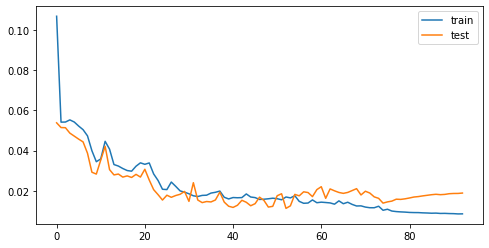

In [18]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

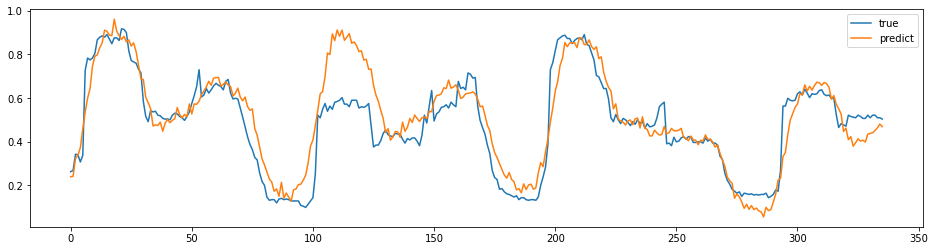

In [19]:
plt.figure(figsize=(16, 4))
y_pred = model.predict(X_test[0:1])[0]
plt.plot(y_test[0], label='true')
plt.plot(y_pred, label='predict')
plt.legend()
plt.show()

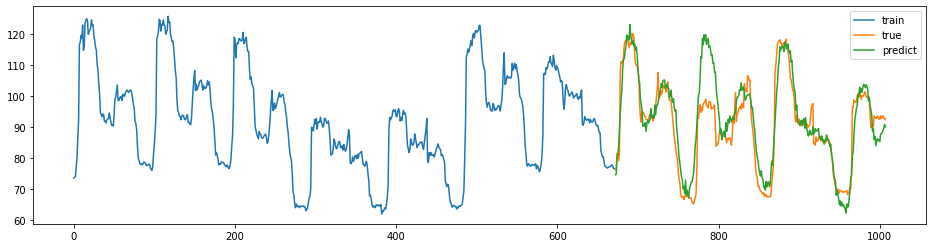

In [20]:
y_pred = model.predict(X_test[0:1])[0]

with open(f'{MODEL_PATH}/scaler_pwr.pkl', 'rb') as f:
    scaler_pwr = pickle.load(f)

plt.figure(figsize=(16, 4))
past = range(len(X_train[0][:, 0]))
future = range(len(X_train[0][:, 0]), len(X_train[0][:, 0]) + len(y_test[0]))
plt.plot(past,
         scaler_pwr.inverse_transform(X_train[-1][:, 0].reshape(-1, 1)),
         label='train')
plt.plot(future,
         scaler_pwr.inverse_transform(y_test[0].reshape(-1, 1)),
         label='true')
plt.plot(future,
         scaler_pwr.inverse_transform(y_pred.reshape(-1, 1)),
         label='predict')
plt.legend()
plt.show()

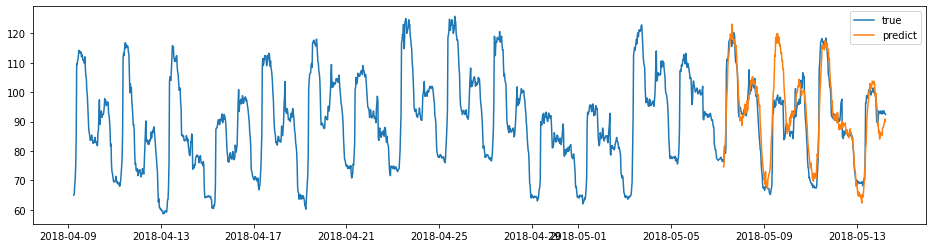

In [21]:
channel_ = pd.DataFrame(
    data=list(df[df['measuringpoint_serial'] == ch_serial].value_text),
    index=list(df[df['measuringpoint_serial'] == ch_serial].timestamp_value)
)
plt.figure(figsize=(16, 4))
start_point = len(X_train) + look_back
plt.plot(channel_[(start_point - 2 * look_back):(start_point + len(y_pred))],
         label='true')
plt.plot(channel_.index[start_point:(start_point + len(y_pred))],
         scaler_pwr.inverse_transform(y_pred.reshape(-1, 1)),
         label='predict')
plt.legend()
plt.show()


### Hyperopt

Мануал по hyperopt https://hyperopt.github.io/hyperopt/

In [22]:
def train_model(X_train, y_train, X_test, y_test,
                units, n_features, dropout, r_dropout, stack,
                loss='mae', patience=40, batch_size=128):
    model = get_model(
        units=units, 
        n_features=n_features, 
        dropout=dropout,
        r_dropout=r_dropout,
        look_back=look_back, 
        look_fwd=look_fwd,
        stack=stack, 
        loss=loss
    )
    checkpoint_path = f'{MODEL_PATH}/model.hdf5'
    earlystopper = EarlyStopping(  # Если качество не растет в течении 40 эпох - будет переобучаться
            monitor='val_loss', 
            patience=patience, 
            verbose=0,
            mode='min'
    )
    lrreducer = ReduceLROnPlateau(  # Уменьшает лернин рейт, если в течении определенном уровне качества стабильно
        monitor='val_loss', 
        factor=.1, 
        patience=int(patience / 2), 
        verbose=0, 
        min_lr=1e-6,
        mode='min'
    )
    checkpointer = ModelCheckpoint( # Сохраняет наилучшую модель, в случае сбоя продолжить.
        checkpoint_path, 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True,
        save_weights_only=True, 
        mode='min'
    )
    callbacks = [earlystopper, checkpointer, lrreducer] # Для проверки что сеть не переобучилась и качество улучшается
    history = model.fit(
        X_train, y_train, 
        epochs=100, 
        batch_size=batch_size, 
        validation_data=(X_test, y_test), 
        verbose=0,
        callbacks=callbacks,
        shuffle=False
    )
    return history, model

In [23]:
PARAMS = {
    'units': 128,
    'dropout': .4,
    'stack': False
}
space = {
    'units': hp.choice('units', [64, 128, 256, 512]),
    'dropout': hp.quniform('dropout', 0, .5, .01),
    'stack': hp.choice('stack', [True, False]),
    'patience': hp.choice('patience', [20, 40]),
}
MAX_EVALS = 50

In [ ]:
PARAMS_OPT = PARAMS.copy()
best_model = None
best_metric = 10e8

def objective(params):
    print('=' * 50)
    global PARAMS_OPT, best_model, best_metric
    PARAMS_OPT.update(params)
    history, model = train_model(
        X_train, y_train, X_test, y_test,
        units=PARAMS_OPT['units'], 
        n_features=6, 
        dropout=PARAMS_OPT['dropout'], 
        r_dropout=0,
        stack=PARAMS_OPT['stack'],
        loss='mse', 
        patience=PARAMS_OPT['patience'],
        batch_size=128
    )
    metric = min(history.history['val_loss'])
    if metric < best_metric:
        best_metric = metric
        best_model = model
        print('found better metric:', best_metric)
    print(f'\nparams: {params} | metric: {metric}\n')
    return metric

best_hopt = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=MAX_EVALS)
print('best search:', best_hopt, '\nbest params:', space_eval(space, best_hopt))
PARAMS_OPT.update(space_eval(space, best_hopt))

params_file = f'{MODEL_PATH}/hopt_params.json'
with open(params_file, 'w') as file:
    json.dump(PARAMS_OPT, file)

found better metric:
0.013592087663710117

params: {'dropout': 0.09, 'patience': 20, 'stack': False, 'units': 128} | metric: 0.013592087663710117


params: {'dropout': 0.01, 'patience': 40, 'stack': True, 'units': 64} | metric: 0.016586698591709137


params: {'dropout': 0.31, 'patience': 20, 'stack': True, 'units': 128} | metric: 0.016431448981165886

found better metric:
0.011289630085229874

params: {'dropout': 0.21, 'patience': 40, 'stack': True, 'units': 512} | metric: 0.011289630085229874


params: {'dropout': 0.16, 'patience': 40, 'stack': False, 'units': 512} | metric: 0.01203224714845419


params: {'dropout': 0.48, 'patience': 40, 'stack': True, 'units': 64} | metric: 0.014453343115746975


params: {'dropout': 0.34, 'patience': 40, 'stack': False, 'units': 256} | metric: 0.012039628811180592

found better metric:
0.010894561186432838

params: {'dropout': 0.2, 'patience': 20, 'stack': False, 'units': 512} | metric: 0.010894561186432838


params: {'dropout': 0.32, 'patience': 20,

In [ ]:
plt.figure(figsize=(16, 4))
y_pred = best_model.predict(X_test[0:1])[0]
plt.plot(y_test[0], label='true')
plt.plot(y_pred, label='predict')
plt.title(f'Best model predictions, best metric={best_metric:.4f}')
plt.legend()
plt.show()